## We try to make a real script based on the Fixed mode spectrum

This log is part of the data_analysis for 1st POLARIS XFEL beamtime at Desy, FLASH (Oct.2018)

(1) Now we are able to scan the energy to see the spectrum. We scan the energy range from 323 eV to 328 eV. We try to use this HDF5 file to generate our first real script.

(2) There is still no Laser information in this HDF5 file.

(3) This script can also be used for electron gun testing

----------- 
 Created by  Hsin-Yi Wang (wang.hy@fysik.su.se), Date: 01-Oct-2018
 
 De-bug by Hsin-Yi Wang (wang.hy@fysik.su.se), Date: 03-Oct-2018 
- Note: This script shuld be operated under Python 3 environment 

### Import modules and useful function

In [77]:
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import h5py
import sys
from os import walk
import os.path
#from mpl_toolkits.axes_grid1 import make_axes_locatable

sys.path.insert(0, '../src/')
import fit_data_tools
from fit_data_tools import *

### Import parameters 

In [82]:
#######################
# Spectrum parameters #
#######################
Escan_Vi = 323 # Initial scanning energy
Escan_Vf = 328 # Final scanning energy
Ep = 100 # Passing energy
N_sweep = 477 # sweep number
files=[1] # File name, ex: files = [1] for XPS001. By now the number should be < 999 
Spectrum_name = ["unknown"] # the name for this spectrum

######################
# Creating threshold #
######################
thr_camera = 8 # smallest blob number per pixel
thr_V = 10 # just use to filt out the data ponit where the voltage/scanning energy reading is zero  
#thr_Laser = 

### Start to do data analysis and polt out the filgure

['FLASH1_USER2_stream_2_run24955_file3_20181003T040820.1.h5'
 'FLASH1_USER2_stream_2_run24955_file5_20181003T041336.1.h5'
 'FLASH1_USER2_stream_2_run24955_file4_20181003T041058.1.h5'
 'FLASH1_USER2_stream_2_run24955_file10_20181003T042648.1.h5'
 'FLASH1_USER2_stream_2_run24955_file1_20181003T040251.1.h5'
 'FLASH1_USER2_stream_2_run24955_file8_20181003T042131.1.h5'
 'FLASH1_USER2_stream_2_run24955_file2_20181003T040541.1.h5'
 'FLASH1_USER2_stream_2_run24955_file9_20181003T042409.1.h5'
 'FLASH1_USER2_stream_2_run24955_file6_20181003T041615.1.h5'
 'FLASH1_USER2_stream_2_run24955_file7_20181003T041853.1.h5']


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater


Check the pixels2V range by two differnt methods for XPS001
AssReal_Escan_Vf = 335.939
Check_AssReal_Escan_Vf = 335.951


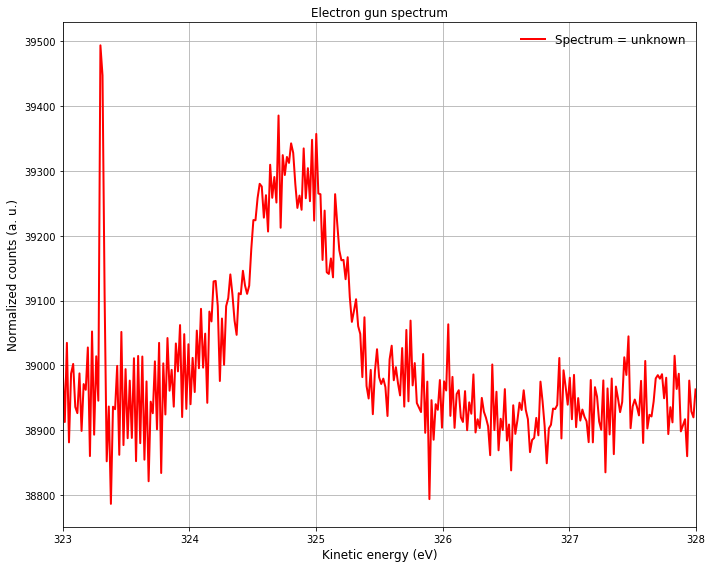

In [83]:
####################################################
# Define the ratio between pixel and energy scale  #
####################################################
Pixels2V = 0.1654*Ep/1000 #  = how much V per pixel

######################
# Load the data file #
######################
i = 0
while i < len(files):
    data_path = '/Users/hsin-yiwang/Desktop/Insitucell_for_XPS/FlashBeamtime/DATA/'+'XPS%03d/' %files[i]
    if not os.path.exists(data_path) :
        print ('XPS%03d does not exist! Check again if you put the right data path or not'%files[i])
    data_names = discover_datas(data_path)
    print (data_names)
    
    #############################################
    # Creating empty matirx for collecting data #
    #############################################

    Total_profile = []
    Extend_total_profile = []
    Total_V = []
    #Laser = []

    #Pump_filter = []
    #Nonpump_filter = []

    ##Pump_Total_profile = []
    #Pump_Total_V = []
    #Pump_Extend_total_profile = []

    #Nonpump_Total_profile = []
    #Nonpump_Total_V = []
    #Nonpump_Extend_total_profile = []

    ################
    # Data process #
    ################
    for j in range(len(data_names)):
        h5file = h5py.File(data_path+data_names[j], 'r')
        Image = h5file['/FL1/Experiment/Camera/PG/Basler FW 1/image/'].value
        #Ind_profile = h5file['/FL1/Experiment/Camera/PG/Basler FW 1/ROI.Y/'].value #The summed individule image along y 
        Voltage_num = h5file['/FL1/Experiment/PG/SIS8300 100MHz ADC/CH6/TD/'].value
        #Laser_reading = h5file['/FL1/Experiment/PG/_______________________'].value
        Image[Image<thr_camera] = 0
        for m in np.arange((Image.shape[0])):
            Ind_profile = np.sum(Image[m,:,:],axis = 0)
            Total_profile.append(Ind_profile)
    
        Ind_voltage_num = np.average(Voltage_num, axis = 1)
        Ind_voltage_num = Ind_voltage_num*650/(2**16)
        Total_V.extend(Ind_voltage_num)
        """
        ## need to check how to access the Laser reading and how it looks like in the HDF5 file
        Laser.append(Laser_reading)  
        """

    Total_profile = np.array(Total_profile)
    Total_V = np.array(Total_V)
    #Laser_reading = np.array(Laer_reading)
    
    Mask_Voltage = Total_V>thr_V
    Total_profile = Total_profile[Mask_Voltage,:]
    Total_V = Total_V[Mask_Voltage]

    """
    Pump_filter.append(Laser>thr_Laser)
    Pump_filter.append(Total_V<thr_V)
    Pump_mask = np.all(Pump_filter, axis=0)
    Pump_Total_profile = Total_profile[Pump_mask,:]
    Pump_Total_V = Total_V[Pump_mask]

    Nonpump_filter.append(Laser<thr_Laser)
    Nonpump_filter.append(Total_V<thr_V)
    Nonpump_mask = np.all(Nonpump_filter, axis=0)
    Nonpump_Total_profile = Total_profile[Nonump_mask,:]
    Nonpump_Total_V = Total_V[Nonump_mask]
    """

    ############################################
    # Convert all energy scale to pixels scale #
    ############################################

    AssFull_pixels_range = np.ceil((Escan_Vf-Escan_Vi)/float(Pixels2V))+ 480*2
    AssFull_pixels_range = int(AssFull_pixels_range)
    AssReal_Escan_Vi = Escan_Vi-480*float(Pixels2V)
    AssReal_Escan_Vf = Escan_Vf+480*float(Pixels2V)
    Check_AssReal_Escan_Vf = AssReal_Escan_Vi+(AssFull_pixels_range)*float(Pixels2V)

    print ('Check the pixels2V range by two differnt methods for XPS%03d' %files[i])
    print ('AssReal_Escan_Vf = %0.3f'%AssReal_Escan_Vf)
    print ('Check_AssReal_Escan_Vf = %0.3f'%Check_AssReal_Escan_Vf)

    for k in np.arange(Total_profile.shape[0]):
        Profile_center = np.ceil((float(Total_V[k])-AssReal_Escan_Vi)/float(Pixels2V))
        Profile_center  = int(Profile_center)
        Extend_profile = np.concatenate([np.zeros(Profile_center-240), Total_profile[k,:], np.zeros(AssFull_pixels_range-Profile_center-240)])
        Extend_total_profile.append(Extend_profile)
    Extend_total_profile = np.array(Extend_total_profile)
    
    #################################################
    # Plot out the data in the desired energy range #
    #################################################
    Spectrum = np.sum(Extend_total_profile,axis = 0)
    Spectrum /= N_sweep
    E_scale = np.arange(AssFull_pixels_range)*float(Pixels2V)+AssReal_Escan_Vi
    SizeSpectrum = Spectrum.shape[0]
    SizeE_scale = E_scale.shape[0]
    if SizeSpectrum != SizeE_scale:
        print("The Spectrum size is not comparable with the Energy_scale size !!")
    
    #Frame = np.all(E_scale >= Escan_Vi, E_scale <= Escan_Vf, axis=0)
    Frame = []
    Frame.append (E_scale >= Escan_Vi)
    Frame.append (E_scale <= Escan_Vf)
    Frame_mask = np.all(Frame,axis=0)
    Spectrum = Spectrum[Frame_mask]
    E_scale = E_scale[Frame_mask]
                                         
    plt.figure(figsize=[10,8])
    plt.plot(E_scale,Spectrum,ls = '-',linewidth ='2', c='red', label = 'Spectrum = %s' %Spectrum_name[i])
    plt.xlabel('Kinetic energy (eV)',size=12)
    plt.ylabel('Normalized counts (a. u.)',size=12)
    plt.title('Electron gun spectrum',size=12)
    plt.grid()
    plt.xlim(Escan_Vi,Escan_Vf)
    plt.tight_layout()
    plt.legend(frameon=False,loc='upper right', prop={'size': 12})
    plt.show()

    #####################
    # Save the data.txt #
    #####################
    #save_path = '/Users/hsin-yiwang/Desktop/Insitucell_for_XPS/FlashBeamtime/DATA/'+'XPS%03d/' %files[i]
    save_path = '/Users/hsin-yiwang/Desktop/Insitucell_for_XPS/FlashBeamtime/DATA/Spectrum' 
    completeName = os.path.join(save_path, "Sepctrum_XPS%03d" %files[i] + ".txt")         
    with open (completeName, "w") as out_file:
        for l in range(len(E_scale)):
            out_string = ""
            out_string += str(E_scale[l])
            out_string += ","+ str(Spectrum[l])
            out_string += "\n"
            out_file.write(out_string)
    i = i+1

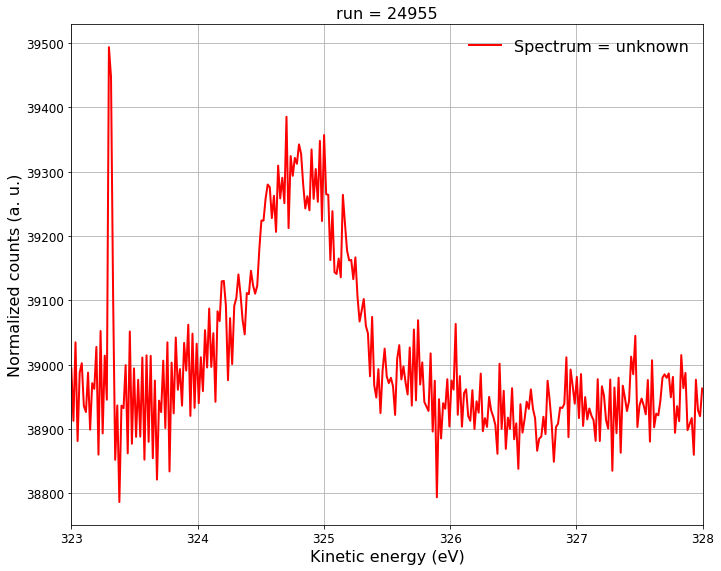

In [103]:
files = [1]
i = 0
while i < len(files) :
    data=np.loadtxt("/Users/hsin-yiwang/Desktop/Insitucell_for_XPS/FlashBeamtime/DATA/Spectrum/Sepctrum_XPS%03d.txt"%files[i], delimiter=',')
    X=(data[:,0])
    Y=(data[:,1])
    plt.figure(figsize=[10,8])
    plt.plot(X,Y,ls = '-',linewidth ='2', c='red', label = 'Spectrum = %s' %Spectrum_name[i])
    plt.xlabel('Kinetic energy (eV)',size=16)
    plt.ylabel('Normalized counts (a. u.)',size=16)
    plt.title('run = 24955',size=16)
    plt.grid()
    plt.xlim(Escan_Vi,Escan_Vf)
    plt.grid(True)
    plt.tight_layout()
    plt.legend(frameon=False,loc='upper right', prop={'size': 16})
    plt.tick_params(axis='both', which='major', labelsize=12)
    #i = i+1 
    plt.show() # push back if you want to individually plot the data
    #plt.savefig('/Users/Hsin-YiWang/Desktop/Spectrum_XPS%03d.png'%files[i], dpi=300)
    i = i+1